### Here i will do some basic Natural Language Processing and Modelling from our email text data from kaggle. In this notebook i will not use deep learning models and any enhanced models like RNN,BERT, etc. I will just use some basic machine learning models to show if it is enough to use basic ML Models to do text classification, in this case spam and non-spam emails classification. Spam emails often to bite our heads off because they are so annoying. Here we hope that we can make our ml model to predict whether an email is spam or ham (not spam).

### For another data science and related projects, kindly visit my github:
https://github.com/danielbeltsazar99/My-Mini-Projects

# Email Spam Analysis and Prediction Modelling

# 1. Install and Import Necessary Libray For NLP and Text Classification

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Email Spam Dataset

In [3]:
df = pd.read_csv('../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.Message = df.Message.astype('str')

# 3. Analysis and Visualization

## 3.1. Distribution of Spam and Non-spam Email 

In [7]:
temp = df.groupby('Category').count()['Message'].reset_index().sort_values(by='Message',ascending=False)
temp.style.background_gradient(cmap='Purples')


,Category,Message
0,ham,4825
1,spam,747


### We will see the visualization of it.

<AxesSubplot:xlabel='Category', ylabel='count'>

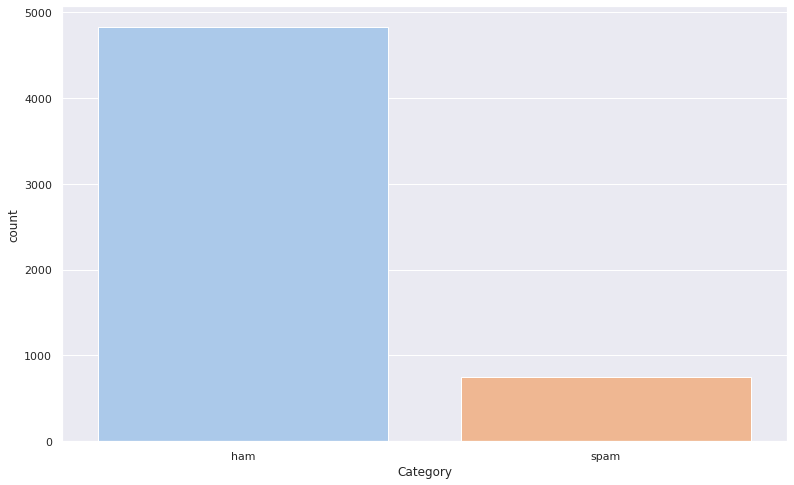

In [8]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='Category',data=df)

### We can see that there are more ham (non-spam emails) than spam emails.

## 3.2. WordCloud of Our Emails

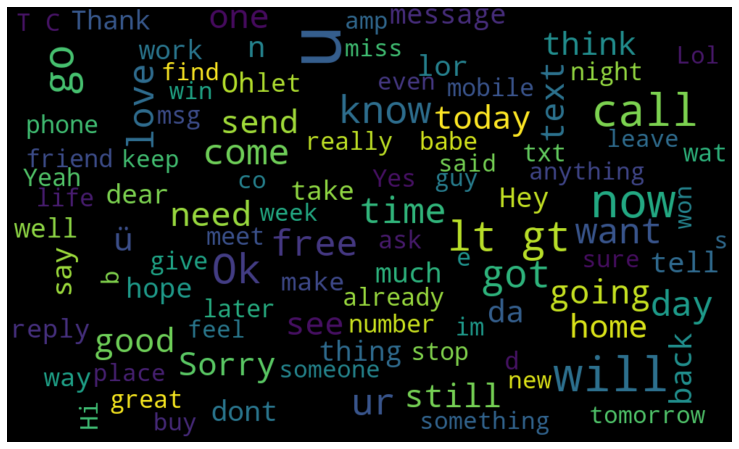

In [9]:
txt = ' '.join(rev for rev in df.Message)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.3. WordCloud of Ham and Spam Emails

In [10]:
ham = df[df['Category']=='ham']
spam = df[df['Category']=='spam']

## Ham Emails

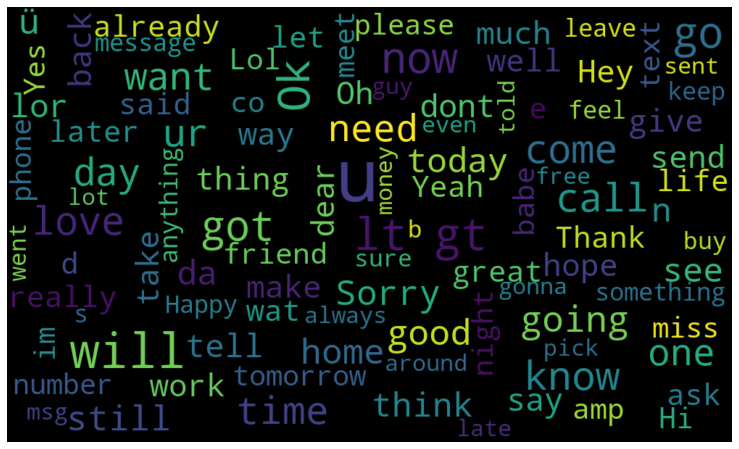

In [11]:
txt = ' '.join(rev for rev in ham.Message)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We can see that for ham (non-spam) emails, the most common words are 'will',  'call',  'going',  'love' , etc as shown in picture above. They are just normal words from normal conversation between someones who know each other. Nothing's suspicious.

## Spam Emails

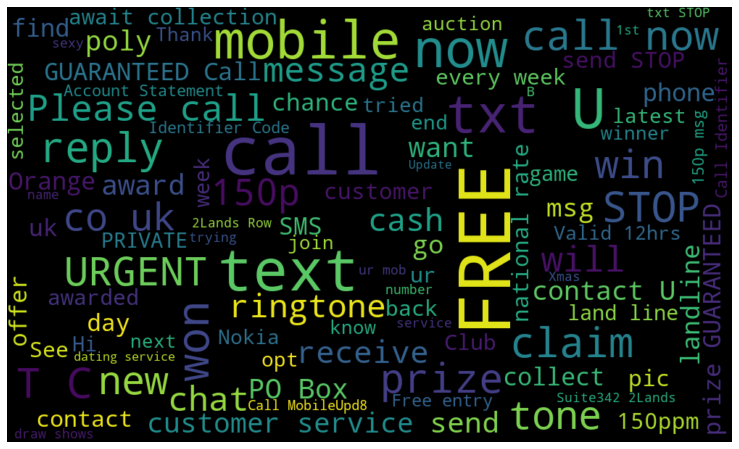

In [12]:
txt = ' '.join(rev for rev in spam.Message)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### And we can see that for spam emails, the most common words are 'Free',  'mobile',  'Call', 'Service', etc as shown in picture above. It seems that most of them are words from ads that offer product or services.

## 3.4. Distribution of Number of Email Words

### First we create additional features to count number of words in each email

In [13]:
df_vis = df.copy()

In [14]:
df_vis['Num_word_email'] = df_vis['Message'].apply(lambda x:len(str(x).split()))

### Than we can plot them

<AxesSubplot:xlabel='Num_word_email', ylabel='Count'>

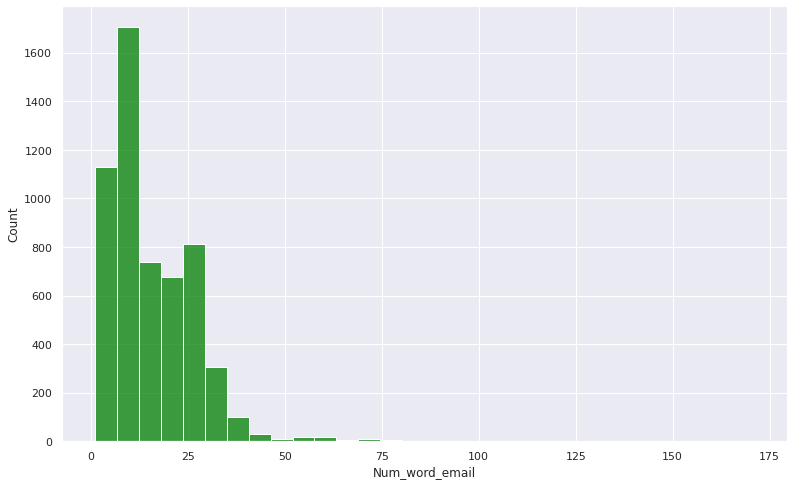

In [15]:
sns.histplot(data=df_vis, x="Num_word_email",bins=30,color='green')

### As we can see that most of our emails contain 1-50 words.

## 3.5. Distribution of Words in All Review Texts

In [16]:
df_vis['temp_list'] = df_vis['Message'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,to,2142
1,you,1626
2,I,1469
3,a,1337
4,the,1204
5,and,858
6,in,798
7,is,787
8,i,748
9,u,696


### Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our email texts.

# 4. Data Cleaning For Sentiment Processing

In [17]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Null values Cleaning

In [18]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

### No missing values detected

### Duplicate Values Removing

In [19]:
df = df.drop_duplicates(keep='first')

In [20]:
df.shape

(5157, 2)

### We make a function to clean some basic characters

In [21]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### We make function to remove numeric

In [22]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make function to remove emoji

In [23]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make function to unify whitespaces

In [24]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make function to remove symbols

In [25]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### We make function to remove punctuation

In [26]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### We make function to remove stopwords

In [27]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### We make function to use stemming to normalize words

In [28]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all the cleaning functions

In [29]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [30]:
cleaning(df,'Message')

In [31]:
df[['Message']].head(20)

,Message
0,go jurong point crazi avail bugi n great world...
1,ok lar joke wif u oni
2,free entri wkli comp win fa cup final tkts st ...
3,u dun say earli hor u c alreadi say
4,nah think goe usf live around though
5,freemsg hey darl week word back like fun still...
6,even brother like speak treat like aid patent
7,per request mell mell oru minnaminungint nurun...
8,winner valu network custom select receivea pri...
9,mobil month u r entitl updat latest colour mob...


### Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [32]:
df_vis2 = df.copy()

In [33]:
df_vis2['temp_list'] = df_vis2['Message'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,u,1062
1,call,559
2,go,440
3,get,427
4,ur,321
5,lt,287
6,come,281
7,ok,252
8,know,252
9,free,246


### We can plot them

<AxesSubplot:xlabel='count', ylabel='Common_words'>

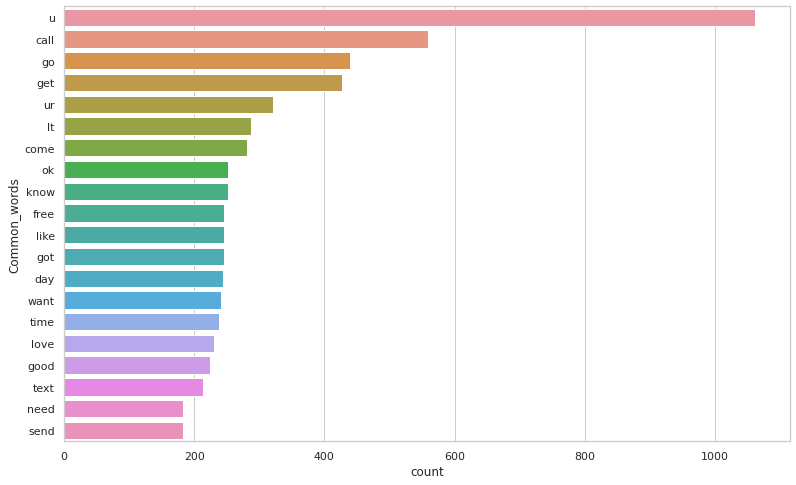

In [34]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

### Then We can see that the word "u" , "call" , "go" are the top 3 common words in our email texts.

# 5. Creating Bag of Words and Text Classifier Model

## 5.1. Creating pipeline for tokenizing and modelling

### Here i use count vectorizer for tokenizing and random forest as classifier model.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=3000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [36]:
df.Category = df.Category.replace({'ham':1,'spam':0})

In [37]:
X = df['Message']
y = df['Category']

## 5.2. Tokenizing and Model Training

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20)


In [39]:
text_classifier = clf.fit(X_train,y_train)

In [40]:
predictions = text_classifier.predict(X_test)

In [41]:
np.unique(predictions)

array([0, 1])

## 5.3. Model's Performance

In [42]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score
confusion_matrix(y_test,predictions)

array([[106,  32],
       [  2, 892]])

In [43]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred)))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [44]:
Confusion_Matrix(y_test,predictions)

TN - True Negative 106
FP - False Positive 32
FN - False Negative 2
TP - True Positive 892
Accuracy Rate: 0.9670542635658915
F1-Score: 0.9812981298129814
Misclassification Rate: 0.03294573643410853
ROC-AUC 0.8829394027818305


<AxesSubplot:>

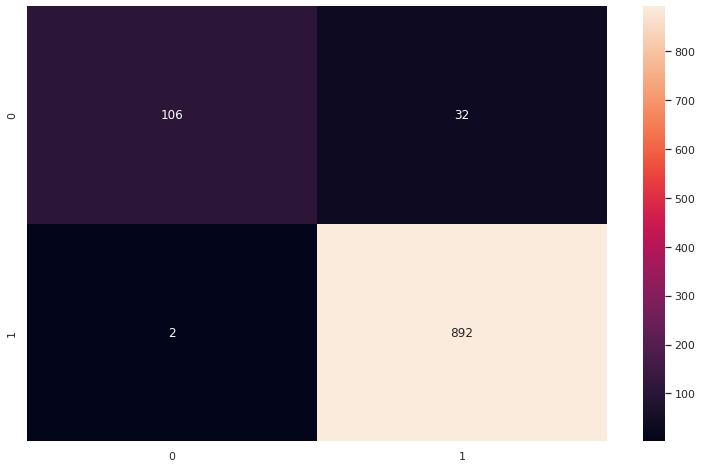

In [45]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

### We see from above confusion matrix that our model has accuracy of 96.7 % and F1-Score of 0.98. It is pretty good. We also have ROC-AUC score of 0.88 where 0.5< our AUC Score <1. So there is a high chance that the our text classifier model will be able to distinguish the ham email class values from the spam email class values.